In [2]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
df = pd.read_csv('../data/train_cleaned.csv')
X = df.drop(columns=['Churn', 'CustomerID'])
y = df['Churn']

In [4]:
# Split the data into training and validation sets with stratification, mantaining proportion in both sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [5]:
X_train.shape, X_val.shape

((195029, 39), (48758, 39))

In [6]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
        tree_method='hist',
        device='cuda',
        n_jobs=1,
        random_state=42,
        eval_metric='logloss'
    ))
])

In [7]:
#kfold and tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

#baseline grid
param_dist = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 6, 10],
    'classifier__scale_pos_weight': [1, 10] # Equivalente a class_weight='balanced'
}

In [8]:
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-2
)

In [9]:
search.fit(X_train, y_train)
best_model = search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [10]:
print("Best Hyperparameters:\n", search.best_params_)

Best Hyperparameters:
 {'classifier__scale_pos_weight': 10, 'classifier__n_estimators': 200, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}


In [11]:
print('best auc in cv:', search.best_score_)

best auc in cv: 0.7442157247199777


In [12]:
#threshold tuning to maximize recall
y_pred_proba = best_model.predict_proba(X_val)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_val, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print('Best threshold:', best_threshold)

Best threshold: 0.78288573


c:\Users\santi\.conda\envs\churn-env\lib\site-packages\xgboost\core.py:774: UserWarning: [02:42:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [13]:
y_pred_tuned = (y_pred_proba >= best_threshold).astype(int)
auc_final = roc_auc_score(y_val, y_pred_proba)

In [16]:
print(f"AUC Score: {auc_final:.4f}")
print(classification_report(y_val, y_pred_tuned))

AUC Score: 0.7466
              precision    recall  f1-score   support

           0       0.90      0.74      0.81     39921
           1       0.35      0.62      0.44      8837

    accuracy                           0.72     48758
   macro avg       0.62      0.68      0.63     48758
weighted avg       0.80      0.72      0.75     48758



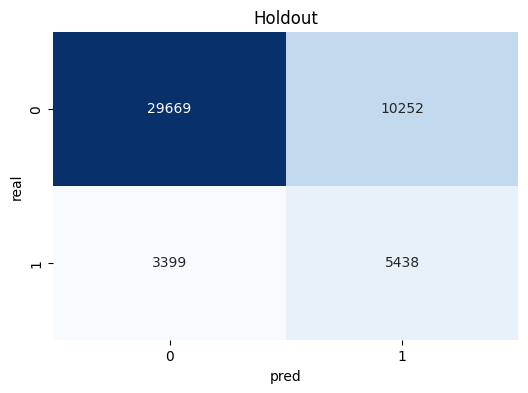

In [18]:
cm = confusion_matrix(y_val, y_pred_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('pred')
plt.ylabel('real')
plt.title('Holdout')
plt.show()